In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle\(2\).json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.12G/2.13G [00:27<00:00, 33.3MB/s]
100% 2.13G/2.13G [00:27<00:00, 83.9MB/s]


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
from keras.applications.inception_v3 import preprocess_input,InceptionV3

Using TensorFlow backend.


In [ ]:
from keras.preprocessing.image import load_img,img_to_array

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input,GlobalAveragePooling2D
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.xception import preprocess_input,Xception
from keras.utils import plot_model
import matplotlib.pyplot as plt
import string
import time

In [ ]:
from keras.preprocessing.image import load_img,img_to_array

In [ ]:
!unzip -q flickr8k.zip

In [ ]:
img_pth = '/content/Flickr_Data/Flickr_Data/Images/'

In [ ]:
train_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'

In [ ]:
test_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

In [ ]:
import glob

In [ ]:
trainset = open(train_pth, 'r', encoding = 'utf-8').read().split("\n")
train_img = []
for im in glob.glob(img_pth+'*.jpg'):
    if im.split('/')[-1] in trainset:
        train_img.append(im)

In [ ]:
testset = open(test_pth, 'r', encoding = 'utf-8').read().split("\n")
test_img = []
for im in glob.glob(img_pth+'*.jpg'):
    if im.split('/')[-1] in testset:
        test_img.append(im)

In [ ]:
caps_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
caps  = open(caps_pth, 'r', encoding = 'utf-8').read()

In [ ]:
def load_caps(caps):
    captions = dict()
    for cap in caps.split("\n"):
        token = cap.split("\t")
        if len(cap) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_cap = token[1]
        if img_id not in captions:
            captions[img_id] = []
        captions[img_id].append(img_cap)
    return captions

In [ ]:
captions = load_caps(caps)

In [ ]:
len(captions)

8092

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords,strip_numeric,strip_punctuation,strip_short

In [ ]:
def clean_caps(caps):
    for key, cap in caps.items():
        for i in range(len(cap)):
            caption = cap[i]
            caption = caption.lower()
            caption = strip_punctuation(caption)
            caption = strip_numeric(caption)
            caption = strip_short(caption,2)
            cap[i] = caption

In [ ]:
clean_caps(captions)

In [ ]:
def load_clean_descriptions(caps, data):
    dat = dict()
    for key, cap in caps.items():
        if key+'.jpg' in data:
            if key not in dat:
                dat[key] = []
            for line in cap:
                c = line
                dat[key].append(c)
    return dat
train_caps = load_clean_descriptions(captions, trainset)
test_caps = load_clean_descriptions(captions, testset)

In [ ]:
def load_im(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img,(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [ ]:
base_model = InceptionV3(weights = 'imagenet',input_shape = (299,299,3))

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
x = base_model.layers[-2]

In [ ]:
from tqdm import tqdm

In [ ]:
encoder = Model(base_model.inputs,x.output)

In [ ]:
def encode_img(img):
    img = load_im(img)
    enc = encoder.predict(img)
    enc = np.reshape(enc, (enc.shape[1]))
    return enc

In [ ]:
train_enc = {}

In [ ]:
!nvidia-smi

Sun Jun 28 13:55:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    59W / 149W |    385MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
for img in tqdm(train_img):
    train_enc[img.split('/')[-1]] = encode_img(img)

100%|██████████| 6000/6000 [05:40<00:00, 17.64it/s]


In [ ]:
test_enc = {}

In [ ]:
for img in tqdm(test_img):
    test_enc[img.split('/')[-1]] = encode_img(img)

100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


In [ ]:
from keras.models import load_model

In [ ]:
net = load_model('bdrlstmglb200')

In [ ]:
net.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 35, 100)      165700      input_36[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 35, 100)      0           embedding_17[0][0]               
___________________________________________________________________________________________

In [ ]:
X1, X2, y = [],[],[]
for key, caps in train_caps.items():
    pic = train_enc[key + '.jpg']
    for cap in caps:
        seq = [word_to_idx[word] for word in cap.split(' ') if word in word_to_idx]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = maxm)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(293370, 2048)


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def greedy_search(pic):
    start = '<start>'
    for i in range(maxm):
        seq = [word_to_idx[word] for word in start.split() if word in word_to_idx]
        seq = pad_sequences([seq], maxlen = maxm)
        yhat = net.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        start += ' ' + word
        if word == '<end>':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
maxm = 35

In [ ]:
word_to_idx = {}
idx_to_word = {}

In [ ]:
def to_vocab(cap):
    words = set()
    for key in cap.keys():
        for line in cap[key]:
            words.update(line.split())
    return words
vocab = to_vocab(captions)
len(vocab)


8424

In [ ]:
train_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'

In [ ]:
trainset = open(train_pth, 'r', encoding = 'utf-8').read().split("\n")
train_img = []
for im in glob.glob(img_pth+'*.jpg'):
    if im.split('/')[-1] in trainset:
        train_img.append(im)

In [ ]:
def load_clean_descriptions(caps, data):
    dat = dict()
    for key, cap in caps.items():
        if key+'.jpg' in data:
            if key not in dat:
                dat[key] = []
            for line in cap:
                c = '<start> '+line+' <end>' 
                dat[key].append(c)
    return dat

train_caps = load_clean_descriptions(captions, trainset)

In [ ]:
train_captions = []
for key, caps in train_caps.items():
    for cap in caps:
        train_captions.append(cap)

In [ ]:
(min(train_captions,key = len).split())

['<start>', 'skier', '<end>']

In [ ]:
vocabulary = vocab
thresh = 10
word_counts = {}
for cap in train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

In [ ]:
len(word_counts)

7320

In [ ]:
vocab = [word for word in word_counts if word_counts[word] >= thresh]

In [ ]:
for idx,word in enumerate(vocab):
    word_to_idx[word] = idx+1
    idx_to_word[idx+1] = word

In [ ]:
vocab_size = len(idx_to_word) + 1 
vocab_size

1657

In [ ]:
maxm = len(max(train_captions,key = len).split())

In [ ]:
maxm

35

In [ ]:
import matplotlib.pyplot as plt

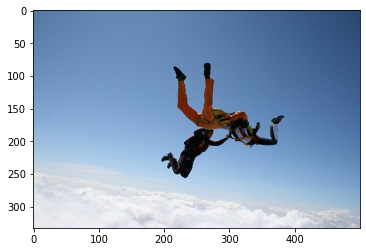

man in midair on bike


In [ ]:
pic = list(test_enc.keys())[250]
img = test_enc[pic].reshape(1, 2048)
x = plt.imread(img_pth + pic)
plt.imshow(x)
plt.show()
out = greedy_search(img)
print(out)

In [ ]:
b1,b2,b3,b4 = [],[],[],[]

In [ ]:
for key,enc in tqdm(test_enc.items()):
  img = enc.reshape(1,2048)
  out = greedy_search(img)
  out = out.split()
  cap = test_caps[key.split('.')[0]]
  cap = [x.split() for x in cap]
  b1.append(sentence_bleu(cap,out,(1.0,0,0,0)))
  b2.append(sentence_bleu(cap,out,(0.5,0.5,0,0)))
  b3.append(sentence_bleu(cap,out,(0.33,0.33,0.33,0)))
  b4.append(sentence_bleu(cap,out,(0.25,0.25,0.25,0.25)))

  0%|          | 1/1000 [00:00<15:51,  1.05it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/1000 [00:02<13:35,  1.22it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 5/1000 [00:03<12:13,  1.36it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [12:58<00:00,  1.28it/s]


0.44242575507948434

In [ ]:
from keras.utils import plot_model

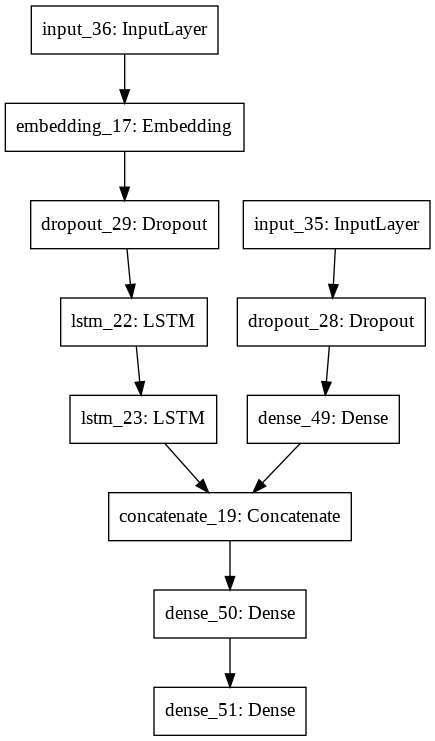

In [ ]:
plot_model(net)